In [12]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from coffea.nanoevents import NanoEventsFactory, PFNanoAODSchema
import os
import warnings
import json

In [2]:
warnings.filterwarnings('ignore', 'Missing')

In [3]:
columns = ['goodjets']
path = '/project01/ndcms/cmoore24/skims/full_skims/nolepton/mc'
hgg = ak.from_parquet(f'{path}/hgg/fd*', columns=columns)
hww = ak.from_parquet(f'{path}/hww/*', columns=columns)

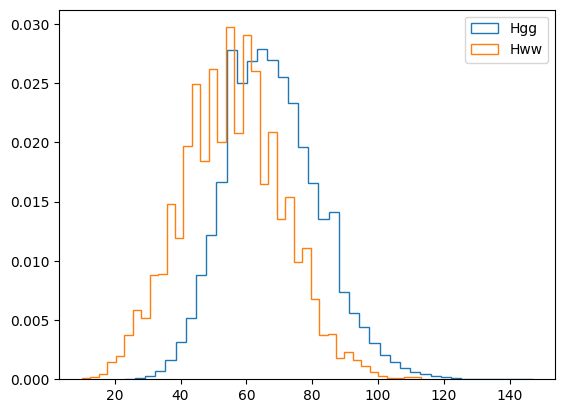

In [25]:
plt.hist(hgg.goodjets.nConstituents, bins=40, histtype='step', label='Hgg', density=True)
plt.hist(goodjets.nConstituents, bins=40, histtype='step', label='Hww', density=True)
plt.legend()
plt.show()

In [5]:
files = os.listdir('/project01/ndcms/cmoore24/samples/hww')
hww_root = NanoEventsFactory.from_root(
    [{f'/project01/ndcms/cmoore24/samples/hww/{file}':'/Events'} for file in files],
    delayed=True, 
    schemaclass=PFNanoAODSchema,
    metadata={'dataset':'Hww'},
).events()

/afs/crc.nd.edu/user/c/cmoore24/miniconda3/envs/coffea/lib/python3.11/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [6]:
hww_root['PFCands', 'pt'] = (
    hww_root.PFCands.pt
    * hww_root.PFCands.puppiWeight
)

In [7]:
cut_to_fix_softdrop = (ak.num(hww_root.FatJet.constituents.pf, axis=2) > 0)
hww_root = hww_root[ak.all(cut_to_fix_softdrop, axis=1)]

In [8]:
hww_root['FatJet', 'num_fatjets'] = ak.num(hww_root.FatJet)

In [9]:
hww_root['FatJet', 'btag_count'] = ak.sum(hww_root.Jet[(hww_root.Jet.pt > 20) & (abs(hww_root.Jet.eta) < 2.4)].btagDeepFlavB > 0.3040, axis=1)

In [10]:
goodmuon = (
            (hww_root.Muon.pt > 10)
            & (abs(hww_root.Muon.eta) < 2.4)
            & (hww_root.Muon.pfRelIso04_all < 0.25) # invert the isolation cut; > 0.25, check for QCD (maybe try > 1.0)
            & hww_root.Muon.looseId
        )

nmuons = ak.sum(goodmuon, axis=1)
leadingmuon = ak.firsts(hww_root.Muon[goodmuon])

goodelectron = (
    (hww_root.Electron.pt > 10)
    & (abs(hww_root.Electron.eta) < 2.5)
    & (hww_root.Electron.cutBased >= 2) #events.Electron.LOOSE
)
nelectrons = ak.sum(goodelectron, axis=1)

ntaus = ak.sum(
    (
        (hww_root.Tau.pt > 20)
        & (abs(hww_root.Tau.eta) < 2.3)
        & (hww_root.Tau.rawIso < 5)
        & (hww_root.Tau.idDeepTau2017v2p1VSjet)
        & ak.all(hww_root.Tau.metric_table(hww_root.Muon[goodmuon]) > 0.4, axis=2)
        & ak.all(hww_root.Tau.metric_table(hww_root.Electron[goodelectron]) > 0.4, axis=2)
    ),
    axis=1,
)

nolepton = ((nmuons == 0) & (nelectrons == 0) & (ntaus == 0))

onemuon = ((nmuons == 1) & (nelectrons == 0) & (ntaus == 0))

In [13]:
with open('../skimmer/triggers.json', 'r') as f:
    triggers = json.load(f)

In [15]:
trigger = ak.zeros_like(ak.firsts(hww_root.FatJet.pt), dtype='bool')
for t in triggers['2017']:
    if t in hww_root.HLT.fields:
        trigger = trigger | hww_root.HLT[t]
trigger = ak.fill_none(trigger, False)

In [16]:
fatjetSelect = (
            (hww_root.FatJet.pt >= 450)
            & (hww_root.FatJet.pt <= 1000)
            & (abs(hww_root.FatJet.eta) <= 2.4)
            & (hww_root.FatJet.msoftdrop >= 40)
            & (hww_root.FatJet.msoftdrop <= 200)
            & (nolepton)
            # & (ak.fill_none(events.FatJet.delta_r(events.FatJet.nearest(events.Muon[goodmuon], axis=1)) > 0.8, True))
            & (trigger)
            & (hww_root.FatJet.btag_count == 0)
        )
genparts = hww_root.GenPart[
    (abs(hww_root.GenPart.pdgId) == 25)
    & hww_root.GenPart.hasFlags(['fromHardProcess', 'isLastCopy'])
]
parents = hww_root.FatJet.nearest(genparts, threshold=0.2)
matched_jets = ~ak.is_none(parents, axis=1)
fatjetSelect = ((fatjetSelect) & (matched_jets))

In [17]:
hww_root["goodjets"] = hww_root.FatJet[fatjetSelect]
mask = ~ak.is_none(ak.firsts(hww_root.goodjets))
hww_root = hww_root[mask]

In [18]:
goodjets = hww_root.goodjets.compute()

In [23]:
goodjets.fields

['area',
 'btagCSVV2',
 'btagDDBvLV2',
 'btagDDCvBV2',
 'btagDDCvLV2',
 'btagDeepB',
 'btagHbb',
 'deepTagMD_H4qvsQCD',
 'deepTagMD_HbbvsQCD',
 'deepTagMD_TvsQCD',
 'deepTagMD_WvsQCD',
 'deepTagMD_ZHbbvsQCD',
 'deepTagMD_ZHccvsQCD',
 'deepTagMD_ZbbvsQCD',
 'deepTagMD_ZvsQCD',
 'deepTagMD_bbvsLight',
 'deepTagMD_ccvsLight',
 'deepTag_H',
 'deepTag_QCD',
 'deepTag_QCDothers',
 'deepTag_TvsQCD',
 'deepTag_WvsQCD',
 'deepTag_ZvsQCD',
 'eta',
 'mass',
 'msoftdrop',
 'n2b1',
 'n3b1',
 'particleNetMD_QCD',
 'particleNetMD_Xbb',
 'particleNetMD_Xcc',
 'particleNetMD_Xqq',
 'particleNet_H4qvsQCD',
 'particleNet_HbbvsQCD',
 'particleNet_HccvsQCD',
 'particleNet_QCD',
 'particleNet_TvsQCD',
 'particleNet_WvsQCD',
 'particleNet_ZvsQCD',
 'particleNet_mass',
 'phi',
 'pt',
 'rawFactor',
 'tau1',
 'tau2',
 'tau3',
 'tau4',
 'lsf3',
 'jetId',
 'subJetIdx1',
 'subJetIdx2',
 'electronIdx3SJ',
 'muonIdx3SJ',
 'nConstituents',
 'DDX_tau1_flightDistance2dSig',
 'DDX_tau1_trackEtaRel_0',
 'DDX_tau1_trackEt